## Optimized RBF_SVM model for trainning set engineering.
## Author: Zhi Li
## Date: 02/06/2019

In [93]:
import os, fnmatch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.svm import SVC
import pydotplus
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, learning_curve
from sklearn.cross_validation import cross_val_score
import optunity
import optunity.metrics

In [69]:
# Data input
file = "PostRunFulldataset.csv"
df = pd.read_csv(file)
Inchi = pd.read_csv("Organic Inchikey.csv")
Inchidict = dict(zip(Inchi['Chemical Name'], Inchi['InChI Key (ID)']))

In [70]:
df.head()

,RunID_vial,_out_crystalscore,_rxn_M_acid,_rxn_M_inorganic,_rxn_M_organic,_rxn_organic-inchikey,_rxn_mixingtime1S,_rxn_mixingtime2S,_rxn_reactiontimeS,_rxn_stirrateRPM,...,_feat_fr_quatN,_feat_fr_ArN,_feat_fr_Ar_NH,_feat_fr_Imine,_feat_fr_amidine,_feat_fr_dihydropyridine,_feat_fr_guanido,_feat_fr_piperdine,_feat_fr_piperzine,_feat_fr_pyridine
0,2017-10-17T16_00_00.000000+00_00_LBL_A1,4,2.923979,1.777256,0.888733,CALQKRVFTWDYDG-UHFFFAOYSA-N,900,1200,9000,500,...,1,0,0,0,0,0,0,0,0,0
1,2017-10-17T16_00_00.000000+00_00_LBL_C1,4,4.779492,1.637406,0.818800,CALQKRVFTWDYDG-UHFFFAOYSA-N,900,1200,9000,500,...,1,0,0,0,0,0,0,0,0,0
2,2017-10-17T16_00_00.000000+00_00_LBL_E1,4,3.576726,1.728058,0.864131,CALQKRVFTWDYDG-UHFFFAOYSA-N,900,1200,9000,500,...,1,0,0,0,0,0,0,0,0,0
3,2017-10-17T16_00_00.000000+00_00_LBL_G1,4,3.576726,1.728058,0.864131,CALQKRVFTWDYDG-UHFFFAOYSA-N,900,1200,9000,500,...,1,0,0,0,0,0,0,0,0,0
4,2017-10-17T16_00_00.000000+00_00_LBL_B1,4,4.779492,1.637406,0.818800,CALQKRVFTWDYDG-UHFFFAOYSA-N,900,1200,9000,500,...,1,0,0,0,0,0,0,0,0,0


In [71]:
# Generate input, output and reference dataframe
X = df.drop(['RunID_vial', '_out_crystalscore', '_rxn_organic-inchikey'], axis =1)
y = df.filter(['_out_crystalscore'])
inchikey = df.filter(['RunID_vial', '_rxn_organic-inchikey']) 

In [72]:
y = (y.replace([1,2,3],0)).replace(4,1) # turned into binary classification

In [94]:
# crossvalidation options
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

In [73]:
# Standarize the features
x = StandardScaler().fit_transform(X)
X = pd.DataFrame(x, index = X.index, columns = X.columns)
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=1)

In [74]:
# Fit trainning sets into optimized RBF SVM
clf = SVC(C=100000,gamma=0.1,cache_size=5000,max_iter=-1,kernel='rbf',\
          decision_function_shape='ovr', probability=False)
clf.fit(X_train, y_train)

SVC(C=100000, cache_size=5000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [75]:
# Function to compute ROC curve and ROC area for each class
def roc (y_test, y_score, name):
    fpr = []
    tpr = []
    thresholds = []
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc=auc(fpr,tpr)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_xlabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    ax.legend(loc="lower right")

Prediction accuracy:  0.8862275449101796
Metric Report
             precision    recall  f1-score   support

          0       0.92      0.93      0.92       364
          1       0.80      0.77      0.79       137

avg / total       0.89      0.89      0.89       501



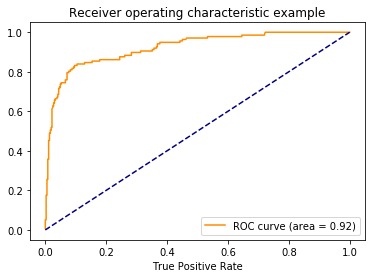

In [76]:
y_score = clf.decision_function(X_test)
y_predict = clf.predict(X_test)
print("Prediction accuracy: ", clf.score(X_test,y_test))
print("Metric Report")
print(classification_report(y_test,y_predict))

# Compute ROC curve and ROC area for each class
roc(y_test,y_score,'_RBF_SVM_ROC.png')

## Learning curve calculation

In [85]:
amine_list = ['Phenethylammonium iodide', 'n-Butylammonium iodide', 'Ethylammonium Iodide', 'Methylammonium iodide', \
               'Guanidinium iodide', 'Acetamidinium iodide', 'Formamidinium Iodide', 'Imidazolium Iodide']

In [77]:
# A function to return score of optimized SVM
def SVM_RBF (X_train,y_train,X_test,y_test):
    clf = SVC(C=100000,gamma=0.1,cache_size=5000,max_iter=-1,kernel='rbf',\
          decision_function_shape='ovr', probability=False)
    clf.fit(X_train, y_train)
    return clf.score(X_test,y_test)

In [91]:
ammonium = 'Acetamidinium iodide'
inchi = Inchidict[ammonium]

# ammonium index in original dataframe
ammonium_index = inchikey.index[inchikey['_rxn_organic-inchikey'] == inchi].tolist()

# index of X_train (ref to original dataframe)
X_train_index = X_train.index.tolist()

# index of support vectors in X_train
X_train_SVs_index = []
for i in clf.support_:
    X_train_SVs_index.append(X_train.index[i])
    
# Find overlap between X_train_index and ammonium_index
X_train_ammonium_index = list(set(X_train_index) & set(ammonium_index))

# Find overlap between X_train_SVs_index and ammonium_index
X_train_SVs_ammonium_index = list(set(X_train_SVs_index) & set(ammonium_index))

# Find the non-SVs of ammonium in X_train
X_train_nonSVs_ammonium_index = list(set(X_train_ammonium_index)-set(X_train_SVs_ammonium_index))

# New_X_train, drop out the non-SVs for target ammonium
New_X_train = X_train.drop(X_train_nonSVs_ammonium_index, axis =0)
New_y_train = y_train.drop(X_train_nonSVs_ammonium_index, axis =0)

# New_X_test: only include target amine
X_test_index = X_test.index.tolist()
X_test_ammonium_index = list(set(X_test_index) & set(ammonium_index))
New_X_test = X_test.filter(X_test_ammonium_index, axis =0)
New_y_test = y_test.filter(X_test_ammonium_index, axis =0)

Predict_top = SVM_RBF(New_X_train, New_y_train, New_X_test, New_y_test)

SVs_predict = []
for i in range(len(X_train_SVs_ammonium_index)):
    X_train_update = New_X_train.drop(X_train_SVs_ammonium_index[i], axis =0)
    y_train_update = New_y_train.drop(X_train_SVs_ammonium_index[i], axis =0)
    SVs_predict.append(SVM_RBF(X_train_update, y_train_update, New_X_test, New_y_test))
    
SVs_importance = -(SVs_predict-Predict_top)
SVs_importance_df = pd.DataFrame({'SVs index': X_train_SVs_ammonium_index, 'SVs importance':SVs_importance})
SVs_importance_df_sorted = SVs_importance_df.sort_values(by=['SVs importance'])
X_train_SVs_ammonium_index_sorted = list(SVs_importance_df_sorted['SVs index'])

predict_subtractSVs = [Predict_top]
X_train_update = New_X_train.copy()
y_train_update = New_y_train.copy()
for i in range(len(X_train_SVs_ammonium_index_sorted)):
    X_train_update = X_train_update.drop(X_train_SVs_ammonium_index_sorted[i], axis =0)
    y_train_update = y_train_update.drop(X_train_SVs_ammonium_index_sorted[i], axis =0)
    predict_subtractSVs.append(SVM_RBF(X_train_update, y_train_update, New_X_test, New_y_test))

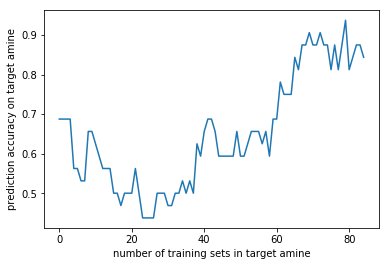

In [92]:
learningCurve = predict_subtractSVs.copy()
learningCurve.reverse()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.arange(len(X_train_SVs_ammonium_ index)+1), learningCurve)
ax.set_xlabel("number of training sets in target amine")
ax.set_ylabel("prediction accuracy on target amine")
plt.savefig("prediction accuracy_vs_training sets for AcetPbI3.png", dpi = 1000)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

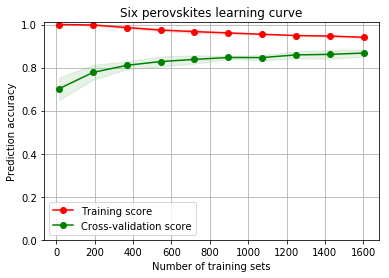

In [107]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, \
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Number of training sets")
    plt.ylabel("Prediction accuracy")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.savefig("learning curve.PNG", dpi = 1000)
    return plt

clf_1 = SVC(C=100000,gamma=0.1,cache_size=5000,max_iter=-1,kernel='rbf',\
          decision_function_shape='ovr', probability=False)
plot_learning_curve(clf_1, title = 'Six perovskites learning curve', X = X_train, y = y_train, \
                    ylim=(0, 1.01), cv=cv, train_sizes = np.linspace(.01, 1.0, 10))

In [101]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y,test_size=0.8,random_state=1)                                                            )

In [102]:
SVM_RBF (X_train_1,y_train_1,X_test_1,y_test_1)

0.8323353293413174